In [1]:
import numpy as np
import pandas as pd
from numpy import pi, r_
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib import rc
from scipy import optimize
from scipy.optimize import minimize
import re
import sys
import subprocess
import math

In [2]:
font = {'size': 16}
rc('font', **font)

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams["lines.linewidth"]=2

plotting=True # plots should be created ?
subplots=True
pico=1.*10**(-12) # picoseconds

In [3]:
# file with QUADRIC analysis of the protein backbone --> has to be done before methyl analysis

inputpath = "."
variant='CI2_WT' 
tumbling = "iso" # iso/ani

outputpath = inputpath+"/"+variant+"/"+tumbling

## Creat output folder
COMMAND = f"mkdir -p {variant}/{tumbling}"
subprocess.call(COMMAND, shell=True)

# Read in input files
tumbling_file=inputpath+"/analysis_"+tumbling+"_"+variant
inputfile_times=inputpath+"/"+variant+"_sch_times.csv"

In [4]:
# Larmor frquency of deuterium
omega_D_field1=2.*pi*92.1298227037992*1000000 # Hr @600 MHz
omega_D_field2=2.*pi*115.138869111022*1000000 # Hz @750 MHz
# frequencies of spectral density used for the fit / usually frequencies measured in NMR

# !!! create array with five frequences  
measuredfreq_field1=np.array([i*omega_D_field1 for i in [0,1,2]])
measuredfreq_field2=np.array([i*omega_D_field2 for i in [0,1,2]])

measuredfreq = np.array([measuredfreq_field1[0], measuredfreq_field2[0],measuredfreq_field1[1], measuredfreq_field2[1],
               measuredfreq_field1[2], measuredfreq_field2[2]])

frequency = np.linspace(0, 2*10**9, 100)

In [5]:
# functions to calculate methyl relaxation rates from spectral density points
def R1(x,y,z):
    return 3./16.*pre**2*(0*x+ 1*y+4*z)
def R2(x,y,z):
    return 1./32.*pre**2*(9*x+15*y+6*z)
def R3(x,y,z):                            
    return 3./16.*pre**2*(0*x+ 3*y+0*z)
def R4(x,y,z):
    return 3./16.*pre**2*(0*x+ 1*y+2*z)

# functios to calculate spectral density points from methyl relaxation rates

pre=2*np.pi*167000 # prefactor based on physical constants
A = 3./16.*pre**2 # prefactor A
B = 1./32.*pre**2 # prefactor B

def J_omega_D(R1,R2,R3):
    return R3/(3*A) - R1*0 - R2*0

def J_2omega_D(R1,R2,R3):
    return (R1/A - R3/(3*A))/4 - R2*0
def J_2omega_D_b(R2,R3,R4):
    return (R4/A - R3/(3*A))/2 - R2*0  

def J_0(R1,R2,R3):
    return ( R2/B - 5*R3/A - 1.5*R1/A + 0.5*R3/A ) /9
def J_0_b(R2,R3,R4):
    return ( R2/B - 5*R3/A - 3*R4/A + R3/A ) /9

# calculate Akaike information criterion
def CHI2(Rmodel,Rnmr,Rerror):
    #print (Rmodel,Rnmr,Rerror)
    return sum([((Rmodel[i]-Rnmr[i])/Rerror[i])**2 for i in [0,1,2]])

# indices of strings for output file
indices=["R1spec_field1","R2spec_field1","R3spec_field1","R1spec_field2","R2spec_field2","R3spec_field2", 
         "SLS2","taufLS2","R1LS2_field1","R2LS2_field1","R3LS2_field1","R1LS2_field2","R2LS2_field2","R3LS2_field2",
         "Jw1LS2_field1","Jw2LS2_field1","Jw3LS2_field1","Jw1LS2_field2","Jw2LS2_field2","Jw3LS2_field2",
         "SLS3","taurLS3","taufLS3","R1LS3_field1","R2LS3_field1","R3LS3_field1","R1LS3_field2","R2LS3_field2","R3LS3_field2",
         "Jw1LS3_field1","Jw2LS3_field1","Jw3LS3_field1","Jw1LS3_field2","Jw2LS3_field2","Jw3LS3_field2","AIC_LS2","AIC_LS3"]

# create empty dataframe of order parameter
order=pd.DataFrame()

relax_times_exp = pd.read_csv(inputfile_times, sep=",", index_col=[0])
relax_times_exp_size= np.size(relax_times_exp,0)

def LS2ns_MC(x,p11,p22):
    return 2./5.*(1./9.*p11*taumps/(1.+(x*taumps)**2)+(1.-1./9.*p11)*taumps*p22/(taumps+p22+(x*taumps*p22)**2/(taumps+p22))) # Lipari-Szabo function
   
def LS3ns_MC(x,p11,p22,p33):    
    return 2./5.*(1./9.*p11*p33/(1.+(x*p33)**2)+(1.-1./9.*p11)*p33*p22/(p33+p22+(x*p33*p22)**2/(p33+p22))) # Lipari-Szabo function

def ERR_STDV(All,A,B,C,D,E,F,G,H):
    return math.sqrt(((A-All)**2+(B-All)**2+(C-All)**2+(D-All)**2+(E-All)**2+(F-All)**2+(G-All)**2+(H-All)**2)/7)



In [6]:
def get_exp_pre_rates (relax_times_exp):
    
    # it is assumed that input "relax_times_exp" contains methyl relaxation times (T1-T4) in miliseconds (ms)  
    # and corresponding uncertainties (errors) in a format: 
    # columns: T1, T1_err, T2, T2 err, etc.
    # rows: individual methyl groups
    
    times=relax_times_exp.iloc[i][::2].values # in ms
    errors = relax_times_exp.iloc[i][1::2].values # in ms
    
    R_exp = 1/(times*0.001) 
    R_err_exp = np.divide(errors/0.001, times**2) 
    
    return R_exp, R_err_exp

In [7]:
# all Chi2_Jpre functions should be stated explicitly and separately to be minimized;
# equations corresponding to the guessed rates should be explicitly stated through Jomegas_pre[x],
# since each Jomegas_pre[x] is going to be minimized

def Chi2_Jpre_all (Jomegas_pre): # x = J_0, y = J_D, z = J_2D
    return  (((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[1]+4*Jomegas_pre[3]))-R1_exp_field1)/R1_err_exp_field1)**2 + \
            (((1./32.*(9*Jomegas_pre[0]+15*Jomegas_pre[1]+6*Jomegas_pre[3]))-R2_exp_field1)/R2_err_exp_field1)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 3*Jomegas_pre[1]+0*Jomegas_pre[3]))-R3_exp_field1)/R3_err_exp_field1)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[1]+2*Jomegas_pre[3]))-R4_exp_field1)/R4_err_exp_field1)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[2]+4*Jomegas_pre[4]))-R1_exp_field2)/R1_err_exp_field2)**2 + \
            (((1./32.*(9*Jomegas_pre[0]+15*Jomegas_pre[2]+6*Jomegas_pre[4]))-R2_exp_field2)/R2_err_exp_field2)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 3*Jomegas_pre[2]+0*Jomegas_pre[4]))-R3_exp_field2)/R3_err_exp_field2)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[2]+2*Jomegas_pre[4]))-R4_exp_field2)/R4_err_exp_field2)**2 

def Chi2_Jpre_noR1_field1 (Jomegas_pre): # x = J_0, y = J_D, z = J_2D
    return  (((1./32.*(9*Jomegas_pre[0]+15*Jomegas_pre[1]+6*Jomegas_pre[3]))-R2_exp_field1)/R2_err_exp_field1)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 3*Jomegas_pre[1]+0*Jomegas_pre[3]))-R3_exp_field1)/R3_err_exp_field1)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[1]+2*Jomegas_pre[3]))-R4_exp_field1)/R4_err_exp_field1)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[2]+4*Jomegas_pre[4]))-R1_exp_field2)/R1_err_exp_field2)**2 + \
            (((1./32.*(9*Jomegas_pre[0]+15*Jomegas_pre[2]+6*Jomegas_pre[4]))-R2_exp_field2)/R2_err_exp_field2)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 3*Jomegas_pre[2]+0*Jomegas_pre[4]))-R3_exp_field2)/R3_err_exp_field2)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[2]+2*Jomegas_pre[4]))-R4_exp_field2)/R4_err_exp_field2)**2

def Chi2_Jpre_noR2_field1 (Jomegas_pre): # x = J_0, y = J_D, z = J_2D
    return  (((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[1]+4*Jomegas_pre[3]))-R1_exp_field1)/R1_err_exp_field1)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 3*Jomegas_pre[1]+0*Jomegas_pre[3]))-R3_exp_field1)/R3_err_exp_field1)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[1]+2*Jomegas_pre[3]))-R4_exp_field1)/R4_err_exp_field1)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[2]+4*Jomegas_pre[4]))-R1_exp_field2)/R1_err_exp_field2)**2 + \
            (((1./32.*(9*Jomegas_pre[0]+15*Jomegas_pre[2]+6*Jomegas_pre[4]))-R2_exp_field2)/R2_err_exp_field2)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 3*Jomegas_pre[2]+0*Jomegas_pre[4]))-R3_exp_field2)/R3_err_exp_field2)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[2]+2*Jomegas_pre[4]))-R4_exp_field2)/R4_err_exp_field2)**2

def Chi2_Jpre_noR3_field1 (Jomegas_pre): # x = J_0, y = J_D, z = J_2D
    return  (((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[1]+4*Jomegas_pre[3]))-R1_exp_field1)/R1_err_exp_field1)**2 + \
            (((1./32.*(9*Jomegas_pre[0]+15*Jomegas_pre[1]+6*Jomegas_pre[3]))-R2_exp_field1)/R2_err_exp_field1)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[1]+2*Jomegas_pre[3]))-R4_exp_field1)/R4_err_exp_field1)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[2]+4*Jomegas_pre[4]))-R1_exp_field2)/R1_err_exp_field2)**2 + \
            (((1./32.*(9*Jomegas_pre[0]+15*Jomegas_pre[2]+6*Jomegas_pre[4]))-R2_exp_field2)/R2_err_exp_field2)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 3*Jomegas_pre[2]+0*Jomegas_pre[4]))-R3_exp_field2)/R3_err_exp_field2)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[2]+2*Jomegas_pre[4]))-R4_exp_field2)/R4_err_exp_field2)**2

def Chi2_Jpre_noR4_field1 (Jomegas_pre): # x = J_0, y = J_D, z = J_2D
    return  (((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[1]+4*Jomegas_pre[3]))-R1_exp_field1)/R1_err_exp_field1)**2 + \
            (((1./32.*(9*Jomegas_pre[0]+15*Jomegas_pre[1]+6*Jomegas_pre[3]))-R2_exp_field1)/R2_err_exp_field1)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 3*Jomegas_pre[1]+0*Jomegas_pre[3]))-R3_exp_field1)/R3_err_exp_field1)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[2]+4*Jomegas_pre[4]))-R1_exp_field2)/R1_err_exp_field2)**2 + \
            (((1./32.*(9*Jomegas_pre[0]+15*Jomegas_pre[2]+6*Jomegas_pre[4]))-R2_exp_field2)/R2_err_exp_field2)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 3*Jomegas_pre[2]+0*Jomegas_pre[4]))-R3_exp_field2)/R3_err_exp_field2)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[2]+2*Jomegas_pre[4]))-R4_exp_field2)/R4_err_exp_field2)**2

def Chi2_Jpre_noR1_field2 (Jomegas_pre): # x = J_0, y = J_D, z = J_2D
    return  (((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[1]+4*Jomegas_pre[3]))-R1_exp_field1)/R1_err_exp_field1)**2 + \
            (((1./32.*(9*Jomegas_pre[0]+15*Jomegas_pre[1]+6*Jomegas_pre[3]))-R2_exp_field1)/R2_err_exp_field1)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 3*Jomegas_pre[1]+0*Jomegas_pre[3]))-R3_exp_field1)/R3_err_exp_field1)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[1]+2*Jomegas_pre[3]))-R4_exp_field1)/R4_err_exp_field1)**2 + \
            (((1./32.*(9*Jomegas_pre[0]+15*Jomegas_pre[2]+6*Jomegas_pre[4]))-R2_exp_field2)/R2_err_exp_field2)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 3*Jomegas_pre[2]+0*Jomegas_pre[4]))-R3_exp_field2)/R3_err_exp_field2)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[2]+2*Jomegas_pre[4]))-R4_exp_field2)/R4_err_exp_field2)**2

def Chi2_Jpre_noR2_field2 (Jomegas_pre): # x = J_0, y = J_D, z = J_2D
    return  (((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[1]+4*Jomegas_pre[3]))-R1_exp_field1)/R1_err_exp_field1)**2 + \
            (((1./32.*(9*Jomegas_pre[0]+15*Jomegas_pre[1]+6*Jomegas_pre[3]))-R2_exp_field1)/R2_err_exp_field1)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 3*Jomegas_pre[1]+0*Jomegas_pre[3]))-R3_exp_field1)/R3_err_exp_field1)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[1]+2*Jomegas_pre[3]))-R4_exp_field1)/R4_err_exp_field1)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[2]+4*Jomegas_pre[4]))-R1_exp_field2)/R1_err_exp_field2)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 3*Jomegas_pre[2]+0*Jomegas_pre[4]))-R3_exp_field2)/R3_err_exp_field2)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[2]+2*Jomegas_pre[4]))-R4_exp_field2)/R4_err_exp_field2)**2

def Chi2_Jpre_noR3_field2 (Jomegas_pre): # x = J_0, y = J_D, z = J_2D
    return  (((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[1]+4*Jomegas_pre[3]))-R1_exp_field1)/R1_err_exp_field1)**2 + \
            (((1./32.*(9*Jomegas_pre[0]+15*Jomegas_pre[1]+6*Jomegas_pre[3]))-R2_exp_field1)/R2_err_exp_field1)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 3*Jomegas_pre[1]+0*Jomegas_pre[3]))-R3_exp_field1)/R3_err_exp_field1)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[1]+2*Jomegas_pre[3]))-R4_exp_field1)/R4_err_exp_field1)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[2]+4*Jomegas_pre[4]))-R1_exp_field2)/R1_err_exp_field2)**2 + \
            (((1./32.*(9*Jomegas_pre[0]+15*Jomegas_pre[2]+6*Jomegas_pre[4]))-R2_exp_field2)/R2_err_exp_field2)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[2]+2*Jomegas_pre[4]))-R4_exp_field2)/R4_err_exp_field2)**2

def Chi2_Jpre_noR4_field2 (Jomegas_pre): # x = J_0, y = J_D, z = J_2D
    return  (((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[1]+4*Jomegas_pre[3]))-R1_exp_field1)/R1_err_exp_field1)**2 + \
            (((1./32.*(9*Jomegas_pre[0]+15*Jomegas_pre[1]+6*Jomegas_pre[3]))-R2_exp_field1)/R2_err_exp_field1)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 3*Jomegas_pre[1]+0*Jomegas_pre[3]))-R3_exp_field1)/R3_err_exp_field1)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[1]+2*Jomegas_pre[3]))-R4_exp_field1)/R4_err_exp_field1)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[2]+4*Jomegas_pre[4]))-R1_exp_field2)/R1_err_exp_field2)**2 + \
            (((1./32.*(9*Jomegas_pre[0]+15*Jomegas_pre[2]+6*Jomegas_pre[4]))-R2_exp_field2)/R2_err_exp_field2)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 3*Jomegas_pre[2]+0*Jomegas_pre[4]))-R3_exp_field2)/R3_err_exp_field2)**2


In [8]:
def use_Chi2_Jpre(Jomegas_pre,Chi2_Jpre):
    
    positive = { 'type': 'ineq', 'fun' : lambda x: np.array(x) }
    opt = { 'maxiter': 500 , 'disp': False}
    
    result = optimize.minimize( Chi2_Jpre, Jomegas_pre, jac = False, constraints = positive, method = 'SLSQP', options = opt )     
    JomegaD = np.array([result.x[0], result.x[1], result.x[2], result.x[3], result.x[4]])/pre**2
    
    return result, JomegaD


1 	 THR3-CG2HG2 	 S2 0.81 ± 0.114 tau_f 48.41 ± 4.95 LS3 AIC 11.40
2 	 VAL9-CG1HG1 	 S2 0.68 ± 0.041 tau_f 65.52 ± 2.83 LS3 AIC 10.32
3 	 VAL9-CG2HG2 	 S2 0.68 ± 0.099 tau_f 42.34 ± 4.10 LS3 AIC 42.54
4 	 VAL13-CG1HG1 	 S2 0.57 ± 0.014 tau_f 100.89 ± 0.80 LS3 AIC 10.31
5 	 VAL13-CG2HG2 	 S2 0.60 ± 0.020 tau_f 44.07 ± 1.27 LS3 AIC 34.14
6 	 ALA16-CBHB 	 S2 0.96 ± 0.025 tau_f 74.24 ± 3.28 LS2 AIC 19.44
7 	 VAL19-CG1HG1 	 S2 0.77 ± 0.101 tau_f 59.43 ± 4.50 LS3 AIC 12.84
8 	 VAL19-CG2HG2 	 S2 0.74 ± 0.125 tau_f 27.12 ± 5.14 LS3 AIC 30.69
9 	 ILE20-CDHD 	 S2 0.65 ± 0.051 tau_f 20.98 ± 2.79 LS3 AIC 22.97
10 	 ILE20-CG2HG2 	 S2 0.92 ± 0.021 tau_f 40.12 ± 2.80 LS2 AIC 32.73
11 	 LEU21-CD1HD1 	 S2 0.59 ± 0.029 tau_f 57.67 ± 1.24 LS3 AIC 9.57
12 	 LEU21-CD2HD2 	 S2 0.61 ± 0.035 tau_f 45.78 ± 2.62 LS3 AIC 15.08
13 	 ALA27-CBHB 	 S2 0.81 ± 0.136 tau_f 38.32 ± 5.81 LS3 AIC 53.44
14 	 ILE29-CDHD 	 S2 0.41 ± 0.061 tau_f 28.44 ± 2.80 LS3 AIC 11.19
15 	 ILE29-CG2HG2 	 S2 0.75 ± 0.076 tau_f 34.20 ± 4.00

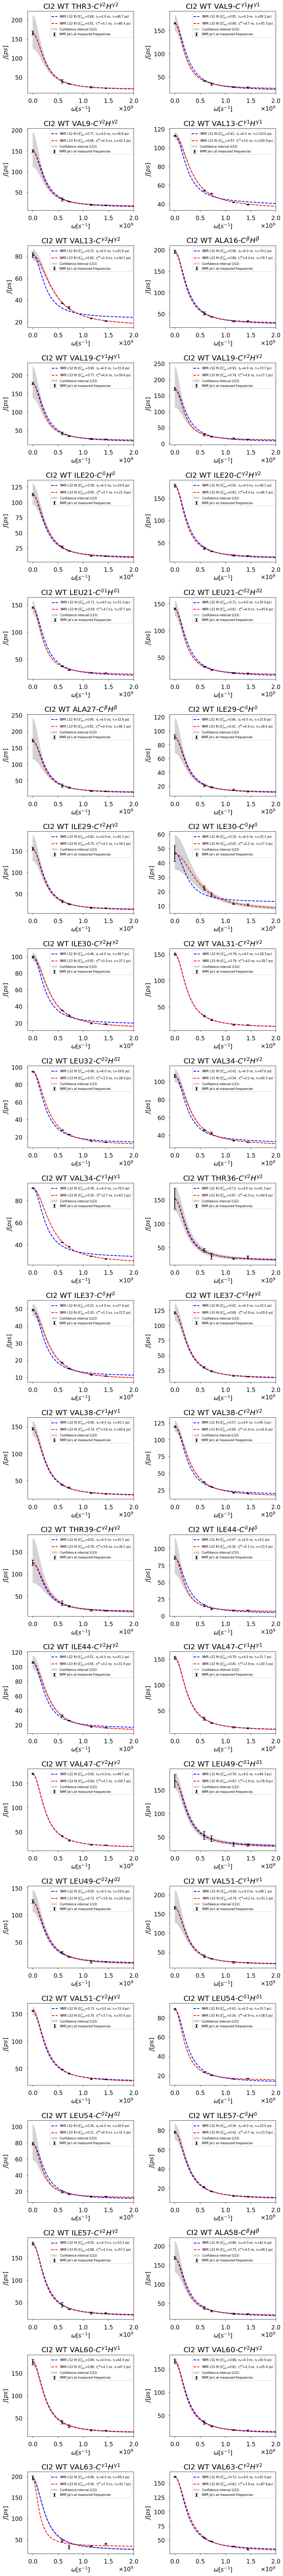

In [9]:
f = open(f"./{variant}_out.txt", 'w')

methID_dict = {"Ala":"ALA", "Ile":"ILE", "Leu":"LEU", "Met":"MET", "Thr":"THR", "Val":"VAL",
               "Cb":"-CB", "Hb":"HB", "Cg1":"-CG1","Cg2":"-CG2", "Hg1":"HG1","Hg2":"HG2","Cd1":"-CD1", "Hd1":"HD1",
               "Cd2":"-CD2", "Hd2":"HD2", "Ce":"-CE", "He":"HE"}
    
# Run a loop for all methyl groups:

fig1, axes1 = plt.subplots(nrows = round(relax_times_exp.shape[0]/2), ncols = 2, figsize = (11, 105))

j=0
for i, ax in enumerate(axes1.flatten()):

    # 1. get experimental rates from the user input
    
    Rates, Rates_err = get_exp_pre_rates(relax_times_exp)    
    
    Rates1to3 = np.array([Rates[0],Rates[1],Rates[2],Rates[4],Rates[5],Rates[6]])
    Rates_err1to3 = np.array([Rates_err[0],Rates_err[1],Rates_err[2],Rates_err[4],Rates_err[5],Rates_err[6]])
  
    # state all the rates explicitly to be further used during minimization
    
    v_count=0
    for field in range(1,3):
        for rate in range(1,5):
            exec(f"R{rate}_exp_field{field} = Rates[{v_count}]") 
            exec(f"R{rate}_err_exp_field{field} = Rates_err[{v_count}]") 
            v_count+=1;
            
      
    # 2. calculate experimental Jomegas based on the experimental rates

    Jzero_field1=J_0(Rates[0],Rates[1],Rates[2]) 
    Jzero_field2=J_0(Rates[4],Rates[5],Rates[6]) # J_0(R1,R2,R3)

    Jzero_field1b=J_0_b(Rates[1],Rates[2],Rates[3]) 
    Jzero_field2b=J_0_b(Rates[5],Rates[6],Rates[7]) # J_0_b(R2,R3,R4)

    Jw_D_field1=J_omega_D(Rates[0],Rates[1],Rates[2]) 
    Jw_D_field2=J_omega_D(Rates[4],Rates[5],Rates[6]) # J_omega_D(R1,R2,R3)
    
    J2w_D_field1=J_2omega_D(Rates[0],Rates[1],Rates[2]) 
    J2w_D_field2=J_2omega_D(Rates[4],Rates[5],Rates[6]) # J_2omega_D(R1,R2,R3)

    J2w_D_field1b=J_2omega_D_b(Rates[1],Rates[2],Rates[3]) 
    J2w_D_field2b=J_2omega_D_b(Rates[5],Rates[6],Rates[7]) # J_2omega_D_b(R2,R3,R4)
    

    # 3. MINIMIZATION USING CHI^2 FUNCTION Chi2_Jpre
    ## DOES NOT WORK WITH LOW NUMBERS (10^-12). CONVERTED TO PICOSECONDS with pre**2

    measuredfreq = np.array([measuredfreq_field1[0],measuredfreq_field1[1], measuredfreq_field2[1], measuredfreq_field1[2], measuredfreq_field2[2]])
    Jomegas_pre = np.array([Jzero_field1, Jw_D_field1, Jw_D_field2, J2w_D_field1, J2w_D_field2])*pre**2  # initial guess of Jomegas (x, y, z)
    
    result_all,JomegaD = use_Chi2_Jpre(Jomegas_pre,Chi2_Jpre_all)
    
    for field in range(1,3):
        for rate in range(1,5):
            exec(f"result_noR{rate}_field{field},JomegaD_noR{rate}_field{field} = use_Chi2_Jpre(Jomegas_pre,Chi2_Jpre_noR{rate}_field{field})")
            
    # 4. Identify the current methyl group and it's tumbling time
     
    methID = relax_times_exp.index[j] 
    
    match = re.search('(\d+)(\w{3})(\w+)_\d+\w{3}(\w+)', methID)
    resN = match.group(1) if match else None
    resName = match.group(2) if match else None
    carbon = match.group(3) if match else None
    hydrogen = match.group(4) if match else None
    
    methIDnew= " %s%s-%s%s" % (resName, resN, carbon, hydrogen)
    
    meth3ID = str(methID_dict[match.group(2)] + match.group(1) + methID_dict[match.group(3)] + methID_dict[match.group(4)])
    if resName=="Ile" and carbon=="Cd1":
        meth3ID=meth3ID.replace("-CD1HD1","-CDHD")
        
                
    with open(tumbling_file) as origin_file: # extract tumbling time from external tumbling
        for line in origin_file:
            match = re.search('(\d+\.\d+)\s*\t*\[(\w{3}\d+\-\w+\d*\w+\d*)\]', line) 
            methylID = match.group(2) if match else None
            if methylID:
                line = match.group(1) if match else None
                taum=float(line)*1000*pico

    # 5. Fit the experimental JomegaD values with LS2 or LS3 analytical functions        
                
    ##LS2 fit
    
    LS2 = lambda p,x: 2./5.*(1./9.*p[0]*taum/(1.+(x*taum)**2)+(1.-1./9.*p[0])*taum*p[1]/(taum+p[1]+(x*taum*p[1])**2/(taum+p[1]))) # Lipari-Szabo function
    errLS2func = lambda p, x, y: LS2(p, x) - y # Distance to the target function
    taumps=taum/pico
    p02 = [0.5, 50] # Initial guess for the parameters
    bounds2_min = [0.,0.]
    bounds2_max = [1.,taumps]
    bounds2 = [bounds2_min, bounds2_max]
    LS2ns = lambda p,x: 2./5.*(1./9.*p[0]*taumps/(1.+(x*taumps)**2)+(1.-1./9.*p[0])*taumps*p[1]/(taumps+p[1]+(x*taumps*p[1])**2/(taumps+p[1]))) # Lipari-Szabo function in ns
    errLS2nsfunc = lambda p, x, y: LS2ns(p, x) - y # Distance to the target function
    p2 = optimize.least_squares(errLS2nsfunc, p02, bounds=bounds2, args=(measuredfreq*pico, JomegaD/pico)) # fit with LS2 function
    p2x=np.array([float(p2.x[0]), float(p2.x[1]*pico)])

    ##LS3 fit

    LS3 = lambda p,x: 2./5.*(1./9.*p[0]*p[2]/(1.+(x*p[2])**2)+(1.-1./9.*p[0])*p[2]*p[1]/(p[2]+p[1]+(x*p[2]*p[1])**2/(p[2]+p[1]))) # Lipari-Szabo function
    errLS3func = lambda p, x, y: LS2(p, x) - y # Distance to the target function
    p03 = [0.5, 100, 5000] # Initial guess for the parameters
    bounds3_min = [0.,0., 1000.]
    bounds3_max = [1.,500,10000]
    bounds3 = [bounds3_min, bounds3_max]
    LS3ns = lambda p,x: 2./5.*(1./9.*p[0]*p[2]/(1.+(x*p[2])**2)+(1.-1./9.*p[0])*p[2]*p[1]/(p[2]+p[1]+(x*p[2]*p[1])**2/(p[2]+p[1]))) # Lipari-Szabo function
    errLS3nsfunc = lambda p, x, y: LS3ns(p, x) - y # Distance to the target function
    p3 = optimize.least_squares(errLS3nsfunc, p03, bounds=bounds3, args=(measuredfreq*pico, JomegaD/pico)) # fit with LS3 function
    p3x=np.array([float(p3.x[0]), float(p3.x[1]*pico), float(p3.x[2]*pico)])

    # 6. calculation of the (anlytical) relaxation rates 
    # based on the minimized JomegaD with chi2 (against experimental data)
    
    for field in range(1,3):
        for rate in range(1,4):
            exec(f"rate{rate}_field{field}=R{rate}(JomegaD[0],JomegaD[1],JomegaD[3])")  
    
     
    # 7. calculation of spectral densities  at measured frequencies for LS2/LS3
    # Since R4 is obsolet, it is not required
                
    
    Jw_LS2 = LS2(p2x,measuredfreq)
    Jw_LS3 = LS3(p3x,measuredfreq)
    
    index1_vec = [0,1,3,0,2,4] # rates order in Jw_LS2/Jw_LS3 
    index1=0

    for field in range(1,3):
        for jw in range(1,4):
                exec(f"Jw{jw}LS2_field{field}=Jw_LS2[{index1_vec[index1]}]")
                exec(f"Jw{jw}LS3_field{field}=Jw_LS3[{index1_vec[index1]}]")
                index1+=1
    
    # 8. rates from LS2/LS3
    ratesLS2=[]
    ratesLS3=[]
    for model in range(2,4):
        for field in range(1,3):
            for rate in range(1,4):
                    exec(f"rate{rate}LS{model}_field{field}=R{rate}(Jw1LS{model}_field{field},Jw2LS{model}_field{field},Jw3LS{model}_field{field})") 
                    exec(f"ratesLS{model}.append(rate{rate}LS{model}_field{field})")
                        
    # 9. Use rates to find if LS2 or LS3 provides better fit (with AIC)
    

    AIC_LS2 = CHI2(ratesLS2,Rates1to3,Rates_err1to3) + 2*2 # CHI2(Rmodel,Rnmr,Rerror)
    AIC_LS3 = CHI2(ratesLS3,Rates1to3,Rates_err1to3) + 3*2 # CHI2(Rmodel,Rnmr,Rerror)
    
    # 10. error estimation for the Jomega values
    # based on comparison of chi2 function (experiment vs fit) condidering all Jw's or excluding one of them
    # and taking stdv between all the combinations
    
    Jw0_ERR_STDV = ERR_STDV(result_all.x[0],result_noR1_field1.x[0],result_noR2_field1.x[0],result_noR3_field1.x[0],result_noR4_field1.x[0],result_noR1_field2.x[0],result_noR2_field2.x[0],result_noR3_field2.x[0],result_noR4_field2.x[0])
    JwD_field1_ERR_STDV = ERR_STDV(result_all.x[1],result_noR1_field1.x[1],result_noR2_field1.x[1],result_noR3_field1.x[1],result_noR4_field1.x[1],result_noR1_field2.x[1],result_noR2_field2.x[1],result_noR3_field2.x[1],result_noR4_field2.x[1])
    JwD2_field1_ERR_STDV = ERR_STDV(result_all.x[2],result_noR1_field1.x[2],result_noR2_field1.x[2],result_noR3_field1.x[2],result_noR4_field1.x[2],result_noR1_field2.x[2],result_noR2_field2.x[2],result_noR3_field2.x[2],result_noR4_field2.x[2])
    JwD_field2_ERR_STDV = ERR_STDV(result_all.x[3],result_noR1_field1.x[3],result_noR2_field1.x[3],result_noR3_field1.x[3],result_noR4_field1.x[3],result_noR1_field2.x[3],result_noR2_field2.x[3],result_noR3_field2.x[3],result_noR4_field2.x[3])
    JwD2_field2_ERR_STDV = ERR_STDV(result_all.x[4],result_noR1_field1.x[4],result_noR2_field1.x[4],result_noR3_field1.x[4],result_noR4_field1.x[4],result_noR1_field2.x[4],result_noR2_field2.x[4],result_noR3_field2.x[4],result_noR4_field2.x[4])
    
    err_Jws = np.array([Jw0_ERR_STDV,JwD_field1_ERR_STDV,JwD2_field1_ERR_STDV,JwD_field2_ERR_STDV,JwD2_field2_ERR_STDV]) 
    
    # 11. ###### MONTE CARLO SIMULATION ##########
    ### TO DEFINE PARAMETERS' (S2, tauf) ERRORS    
    
    if AIC_LS2<=AIC_LS3: 
        LSns_MC = LS2ns_MC
        vGuess = [0.5,50]
    else:
        LSns_MC = LS3ns_MC
        vGuess = [0.5,100,5000]
        
    sError = err_Jws # error based on using all Jw's vs excluding obsolete Jw's. This way the error is based only on the variations in the experimental data
    nTrials = 4000
    aFitPars = np.array([])
    
    
    for iTrial in range(nTrials):
        xTrial = measuredfreq*pico
        yGen = JomegaD/pico
        yTrial = yGen + np.random.normal(scale=sError,size=np.size(yGen))

        # We use a try/except clause to catch pathologies
        try:                
                vTrial, aCova = optimize.curve_fit(LSns_MC,xTrial,yTrial,vGuess)

        except:

            continue  # This moves us to the next loop without stacking.
            
        #here follows the syntax for stacking the trial onto the running sample:
        if np.size(aFitPars) < 1:
            aFitPars=np.copy(vTrial)
        else:
            aFitPars = np.vstack(( aFitPars, vTrial ))
        
    S2_tauf_MC_std=np.array([float(np.median(aFitPars[:,0])), float(np.std(aFitPars[:,0])), \
                             float(np.median(aFitPars[:,1])), float(np.std(aFitPars[:,1]))])
    
    if AIC_LS2<=AIC_LS3:
        S2_tauf_MC_stdOnly=np.array([float(np.std(aFitPars[:,0])), float(np.std(aFitPars[:,1]))*pico])
        
        p2x_min = p2x-S2_tauf_MC_stdOnly
        p2x_max = p2x+S2_tauf_MC_stdOnly
      
    else:
        S2_tauf_MC_stdOnly=np.array([float(np.std(aFitPars[:,0])), float(np.std(aFitPars[:,1]))*pico, float(np.std(aFitPars[:,2]))*pico])

        p3x_min = p3x-S2_tauf_MC_stdOnly
        p3x_max = p3x+S2_tauf_MC_stdOnly
    
    ####### END MONTE CARLO SIMULATION ##########

    values=[rate1_field1,rate2_field1,rate3_field1,rate1_field2,rate2_field2,rate3_field2,
            p2x[0],p2x[1],rate1LS2_field1,rate2LS2_field1,rate3LS2_field1,rate1LS2_field2,rate2LS2_field2,rate3LS2_field2,
            Jw1LS2_field1,Jw2LS2_field1,Jw3LS2_field1,Jw1LS2_field2,Jw2LS2_field2,Jw3LS2_field2,
            p3x[0],p3x[2],p3x[1],rate1LS3_field1,rate2LS3_field1,rate3LS3_field1,rate1LS3_field2,rate2LS3_field2,rate3LS3_field2,
            Jw1LS3_field1,Jw2LS3_field1,Jw3LS3_field1,Jw1LS3_field2,Jw2LS3_field2,Jw3LS3_field2,AIC_LS2,AIC_LS3] # all results in one array
    
    
    output=pd.DataFrame(values,indices) # dataframe describing the output which will be written to the file
    output.to_csv(outputpath+"/params_"+meth3ID,sep=" ", header=False) # write values to file

    j += 1    
    
    # PLOTTING
    
    # Make a dictionary for latex formatting in the plot titles:
    latex_title = {"CBHB": r"-$C^{\beta}H^{\beta}$",
                   "CDHD": r"-$C^{\delta}H^{\delta}$",
                   "CEHE": r"-$C^{\epsilon}H^{\epsilon}$",
                   "CD1HD1": r"-$C^{\delta1}H^{\delta1}$",
                   "CD2HD2": r"-$C^{\delta2}H^{\delta2}$",
                   "CG1HG1": r"-$C^{\gamma1}H^{\gamma1}$",
                   "CG2HG2": r"-$C^{\gamma2}H^{\gamma2}$"}

    
    if plotting:
        plt.figure(figsize=(6,4))
        edge=0.2
        ax = plt.subplot(111)
        plt.subplots_adjust(bottom=edge, left=edge)
        ax.tick_params(pad=10)
        plt.title(variant[:3]+" "+variant[4:]+" "+meth3ID.split("-")[0]+latex_title[meth3ID.split("-")[1]], fontsize=20)

        plt.plot(frequency, LS2(p2x, frequency)/pico, c="b", linestyle="--", label=r'NMR LS2 fit ($S^\mathrm{2}_\mathrm{axis}$='+str("%.2f" % round(p2x[0],2))+r', $\tau_\mathrm{R}$='+str("%.1f" % round(taum/1000/pico,1))+r' ns, $\tau_\mathrm{f}$='+str("%.1f" % round(p2x[1]/pico,1))+r' ps)')
        
        if AIC_LS2<=AIC_LS3:
            plt.fill_between(frequency,LS2(p2x_min,frequency)/pico,LS2(p2x_max,frequency)/pico,facecolor='lightgrey', interpolate=True, edgecolors="None",label="Confidence interval (LS2)")        
        else:
            plt.fill_between(frequency,LS3(p3x_min,frequency)/pico,LS3(p3x_max,frequency)/pico,facecolor='lightgrey', interpolate=True, edgecolors="None",label="Confidence interval (LS3)")        
   
        plt.plot(frequency, LS3(p3x, frequency)/pico, c="r", linestyle="--", label=r'NMR LS3 fit ($S^\mathrm{2}_\mathrm{axis}$='+str("%.2f" % round(p3x[0],2))+r', $\tau_\mathrm{c}^\mathrm{eff}$='+str("%.1f" % round(p3.x[2]/1000,1))+r' ns, $\tau_\mathrm{f}$='+str("%.1f" % round(p3.x[1],1))+r' ps)') # Plot of the data and the fit
        
        plt.errorbar(measuredfreq, JomegaD/pico, yerr=err_Jws, c="k", linestyle="None", fmt='o', capsize = 4, label="NMR Jw's at measured frequencies", ms=3)
        plt.xlabel(r'$\omega [s^{-1}]$')
        plt.ylabel(r'$J[ps]$')
        ax.xaxis.set_major_formatter(mtick.ScalarFormatter(useMathText=True))
        ax.yaxis.set_major_formatter(mtick.ScalarFormatter(useMathText=True))
        plt.xlim(-10**8,2*10**9)
        plt.legend(numpoints=1, fontsize=8)
        plt.savefig(outputpath+"/spec_dens_"+meth3ID+".pdf",dpi=600)
        plt.close()

 # Plot spectral density:
    if subplots:

        ax = plt.subplot(round(relax_times_exp.shape[0]/2), 2, j)
        plt.subplots_adjust(top=0.99, right=0.99)
        ax.tick_params(pad=10)
        
        ax.plot(frequency, LS2(p2x, frequency)/pico, c="b", linestyle="--", label=r'NMR LS2 fit ($S^\mathrm{2}_\mathrm{axis}$='+str("%.2f" % round(p2x[0],2))+r', $\tau_\mathrm{R}$='+str("%.1f" % round(taum/1000/pico,1))+r' ns, $\tau_\mathrm{f}$='+str("%.1f" % round(p2x[1]/pico,1))+r' ps)')
        
        if AIC_LS2<=AIC_LS3:
            ax.fill_between(frequency,LS2(p2x_min,frequency)/pico,LS2(p2x_max,frequency)/pico,facecolor='lightgrey', interpolate=True, edgecolors="None",label="Confidence interval (LS2)")        
        else:
            ax.fill_between(frequency,LS3(p3x_min,frequency)/pico,LS3(p3x_max,frequency)/pico,facecolor='lightgrey', interpolate=True, edgecolors="None",label="Confidence interval (LS3)")        
 
        ax.plot(frequency, LS3(p3x, frequency)/pico, c="r", linestyle="--", label=r'NMR LS3 fit ($S^\mathrm{2}_\mathrm{axis}$='+str("%.2f" % round(p3x[0],2))+r', $\tau_\mathrm{c}^\mathrm{eff}$='+str("%.1f" % round(p3.x[2]/1000,1))+r' ns, $\tau_\mathrm{f}$='+str("%.1f" % round(p3.x[1],1))+r' ps)') # Plot of the data and the fit
        
        ax.errorbar(measuredfreq, JomegaD/pico, yerr=err_Jws, c="k", linestyle="None", fmt='o', capsize = 4, label="NMR Jw's at measured frequencies", ms=3)

        ax.set_xlabel(r'$\omega [s^{-1}]$')
        ax.set_ylabel(r'$J[ps]$')
        plt.title(variant[:3]+" "+variant[4:]+" "+meth3ID.split("-")[0]+latex_title[meth3ID.split("-")[1]], fontsize=20)

        ax.xaxis.set_major_formatter(mtick.ScalarFormatter(useMathText=True))
        ax.yaxis.set_major_formatter(mtick.ScalarFormatter(useMathText=True))
        plt.xlim(-10**8,2*10**9)
        plt.legend(numpoints=1, fontsize=8, loc = 1)
   
    order_new = pd.DataFrame(columns = ["methylID_full", "S2_LS2", "AIC_LS2", "S2_LS3", "AIC_LS3", "LS", "AIC", "S2", "S2_er", "tauf", "tauf_er"])
  
    if AIC_LS2<=AIC_LS3:
        order_new = order_new.append(pd.DataFrame({"methylID_full": meth3ID, "S2_LS2":[float(p2x[0])],"AIC_LS2": AIC_LS2, 
                                                       "S2_LS3":[float(p3x[0])],"AIC_LS3": AIC_LS3,"LS":"LS2","AIC":AIC_LS2, "S2":[float(p2x[0])],"S2_er":[float(S2_tauf_MC_std[1])], 
                                                       "tauf":p2.x[1],"tauf_er": S2_tauf_MC_std[3]}, index = [0]), ignore_index = True, sort=False)
        
        print (j,"\t",meth3ID,"\t","S2", "%.2f" % p2x[0],"±", "%.3f" % S2_tauf_MC_std[1],"tau_f", "%1.2f" % p2.x[1],"±", "%.2f" % S2_tauf_MC_std[3] ,"LS2 AIC", "%.2f" % AIC_LS2)
        print (j,"\t",meth3ID,"\t","S2", "%.2f" % p2x[0],"±", "%.3f" % S2_tauf_MC_std[1],"tau_f", "%1.2f" % p2.x[1],"±", "%.2f" % S2_tauf_MC_std[3] ,"LS2 AIC", "%.2f" % AIC_LS2, file=f)

    else:
        order_new = order_new.append(pd.DataFrame({"methylID_full": meth3ID, "S2_LS2":[float(p2x[0])],"AIC_LS2": AIC_LS2, 
                                                       "S2_LS3":[float(p3x[0])],"AIC_LS3": AIC_LS3,"LS":"LS3","AIC":AIC_LS3, "S2":[float(p3x[0])],"S2_er":[float(S2_tauf_MC_std[1])], 
                                                       "tauf":p3.x[1],"tauf_er": S2_tauf_MC_std[3]}, index = [0]), ignore_index = True, sort=False)
        
        print (j,"\t",meth3ID,"\t","S2", "%.2f" % p3x[0],"±", "%.3f" % S2_tauf_MC_std[1],"tau_f", "%1.2f" % p3.x[1],"±", "%.2f" % S2_tauf_MC_std[3] ,"LS3 AIC", "%.2f" % AIC_LS3)
        print (j,"\t",meth3ID,"\t","S2", "%.2f" % p3x[0],"±", "%.3f" % S2_tauf_MC_std[1],"tau_f", "%1.2f" % p3.x[1],"±", "%.2f" % S2_tauf_MC_std[3] ,"LS3 AIC", "%.2f" % AIC_LS3, file=f)

        
    order = order.append(order_new) # append order parameter to dataframe containing all order parameter

order.to_csv(outputpath+"/order_"+variant+"_methyl.dat",header=True,sep="\t", float_format='%5.3f') # write order parameter to file
print ("Printing the plots...")

if subplots:      
    fig1.tight_layout(rect=[0, 0.03, 1, 0.96])
    fig1.savefig(str(outputpath+"/"+variant+"_spec_dens.pdf"), dpi = 1200, bbox_inches='tight') 
    
f.close()
